# Simulasi Dinamika Suhu Harian di Kota Delhi  
## Menggunakan Metode Runge-Kutta Orde 4 (RK4)

**Mata Kuliah**: Praktikum Pemodelan dan Simulasi  
**Tugas**: Tugas Akhir 10 (TA-10)  
**Metode Numerik**: Runge-Kutta Orde 4 (RK4)  

Notebook ini bertujuan untuk mensimulasikan dinamika suhu harian Kota Delhi menggunakan
persamaan diferensial biasa dan metode Runge-Kutta Orde Empat (RK4), serta membandingkan
hasil simulasi dengan data suhu riil.


## 1. Import Library
Library yang digunakan dalam simulasi ini meliputi pustaka untuk pengolahan data,
komputasi numerik, visualisasi, dan optimasi parameter.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


## 2. Load dan Persiapan Data

Dataset yang digunakan adalah **DailyDelhiClimateTest.csv** yang diperoleh dari Kaggle.
Pada penelitian ini, hanya variabel **suhu rata-rata harian (meantemp)** yang digunakan
sebagai representasi sistem dinamis.


In [22]:
# Load dataset
df = pd.read_csv('DailyDelhiClimateTest.csv')

# Konversi kolom tanggal
df['date'] = pd.to_datetime(df['date'])

# Ambil kolom relevan
data = df[['date', 'meantemp']].copy()

# Buat variabel waktu (hari ke-n)
data['t'] = np.arange(len(data))

# Ambil array waktu dan suhu
t_data = data['t'].values
temp_data = data['meantemp'].values

# Kondisi awal
T0 = temp_data[0]

print("Jumlah data:", len(temp_data))
print("Suhu awal:", T0)


Jumlah data: 114
Suhu awal: 15.91304347826087


## 3. Model Persamaan Diferensial

Model yang digunakan adalah model relaksasi suhu orde satu:

\[
\frac{dT}{dt} = k (T_{eq} - T)
\]

dengan:
- \(T(t)\): suhu harian
- \(k\): konstanta laju perubahan suhu
- \(T_{eq}\): suhu keseimbangan lingkungan


In [23]:
def model_temperature(t, T, k, T_eq):
    return k * (T_eq - T)


## 4. Implementasi Runge-Kutta Orde 4 (RK4)

Metode RK4 digunakan untuk menyelesaikan persamaan diferensial secara numerik dengan
menggunakan empat estimasi kemiringan pada setiap langkah waktu.


In [24]:
def rk4_solver(f, t0, y0, t_end, h, params):
    t_values = np.arange(t0, t_end + h, h)
    y_values = np.zeros(len(t_values))
    y_values[0] = y0
    
    for i in range(len(t_values) - 1):
        t = t_values[i]
        y = y_values[i]
        
        k1 = h * f(t, y, *params)
        k2 = h * f(t + h/2, y + k1/2, *params)
        k3 = h * f(t + h/2, y + k2/2, *params)
        k4 = h * f(t + h, y + k3, *params)
        
        y_values[i+1] = y + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return t_values, y_values


## 5. Eksperimen Tuning Parameter (Grid Search)

Parameter \(k\) dan \(T_{eq}\) dicari menggunakan metode grid search dengan
meminimalkan nilai Root Mean Square Error (RMSE).


In [25]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

k_range = np.linspace(0.01, 0.5, 30)
T_eq_range = np.linspace(np.min(temp_data), np.max(temp_data), 30)

best_rmse = np.inf
best_params = None

t0 = 0
t_end = len(temp_data) - 1
h = 1

for k in k_range:
    for T_eq in T_eq_range:
        _, T_sim = rk4_solver(
            model_temperature,
            t0,
            T0,
            t_end,
            h,
            params=(k, T_eq)
        )
        error = rmse(temp_data, T_sim)
        if error < best_rmse:
            best_rmse = error
            best_params = (k, T_eq)

k_opt, T_eq_opt = best_params

print("Parameter optimal:")
print("k =", k_opt)
print("T_eq =", T_eq_opt)
print("RMSE =", best_rmse)


Parameter optimal:
k = 0.01
T_eq = 32.87931034482759
RMSE = 4.04172845315466


## 6. Simulasi RK4 dengan Parameter Optimal


In [26]:
t_sim, T_sim_opt = rk4_solver(
    model_temperature,
    t0,
    T0,
    t_end,
    h,
    params=(k_opt, T_eq_opt)
)


## 7. Visualisasi Perbandingan Data Asli dan Simulasi RK4


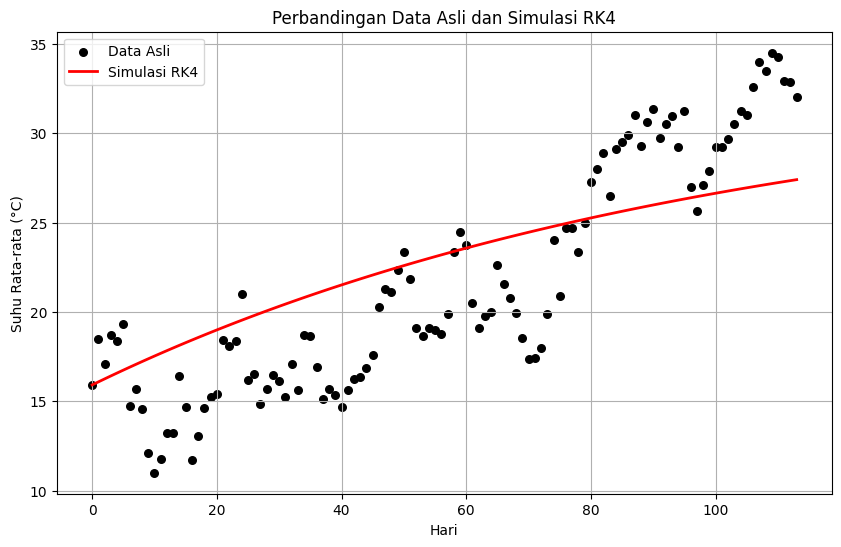

In [27]:
plt.figure(figsize=(10,6))
plt.scatter(t_data, temp_data, label='Data Asli', color='black', s=30)
plt.plot(t_sim, T_sim_opt, label='Simulasi RK4', color='red', linewidth=2)

plt.xlabel('Hari')
plt.ylabel('Suhu Rata-rata (°C)')
plt.title('Perbandingan Data Asli dan Simulasi RK4')
plt.legend()
plt.grid(True)
plt.show()


## 8. Interpretasi Hasil

Nilai konstanta laju perubahan suhu (k) menunjukkan kecepatan respons suhu terhadap
perubahan lingkungan. Nilai suhu keseimbangan (T_eq) merepresentasikan suhu jangka
panjang yang menjadi titik konvergensi sistem.

Nilai RMSE yang relatif kecil menunjukkan bahwa metode RK4 mampu merepresentasikan
tren utama perubahan suhu harian dengan cukup baik, meskipun fluktuasi ekstrem tidak
sepenuhnya dapat ditangkap oleh model sederhana ini.
